In [16]:
import numpy as np
import pandas as pd
import os

In [17]:
df = pd.read_csv('df_transactions.csv')

In [18]:
df

,hash,nonce,transaction_index,from_address,to_address,ether_transferred,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_hash,block_number
0,0xef0a10e704911070a1f6254e7232c9ce4c3262cf8e0b...,704,9,0x4d4da657fda69460f8083120089ae066f3655108,0x14036de12ac0c96d4d5ed03e150d6558a43bbee5,0.100178,846761,9818233639,0x5327a3d2000000000000000000000000000000000000...,2526674,664998,NaN,NaN,1,2024-10-20 08:10:47+00:00,0x459c09c033eec594589627d11131e460d630879eb633...,21005508
1,0x799e14bce91bfca44bf2013e2350011a17cb2f7e4f0c...,0,186,0xc06b0b551a7f2ec79fdcb1c38d4f90f106e581ac,0xe21757357d5e37732b9e00bac8419dbd905cecc2,1.000000,23100,8936023203,0x,17822578,21000,NaN,NaN,1,2024-10-20 08:10:47+00:00,0x459c09c033eec594589627d11131e460d630879eb633...,21005508
2,0xdfd786cb2fcb82b22a601839075ed2087b5b8251a1f9...,2,221,0x265a7127d191705125531a38e6d60326b65c3b0a,0xdac17f958d2ee523a2206206994597c13d831ec7,0.000000,69718,9897023203,0xa9059cbb000000000000000000000000eb7144747917...,20296428,46097,NaN,NaN,1,2024-10-20 08:10:47+00:00,0x459c09c033eec594589627d11131e460d630879eb633...,21005508
3,0xc23ed620b3102d728047d3bc541ed96de56410a57792...,8,113,0x860a37a367f46a3f3559f90830ca1c6a0ae8b7d9,0x7f7de814d364dc5d6dab63bad14270ab762785a2,0.000000,98603,10000000000,0xa9059cbb000000000000000000000000945948724b91...,10111118,39727,NaN,NaN,1,2024-10-20 08:11:59+00:00,0xbd202e917632101d40149716489c1a9c74a7884aba3b...,21005514
4,0x12d7f4f1d56f3b9fc52cceffcc262a4db19be76bcf39...,9887093,37,0xdfd5293d8e347dfe59e90efd55b2956a1343963d,0x4d224452801aced8b2f0aebe155379bb5d594381,0.000000,207128,11599483892,0xa9059cbb000000000000000000000000fa103c21ea2d...,6421870,51609,NaN,NaN,1,2024-10-20 08:11:59+00:00,0xbd202e917632101d40149716489c1a9c74a7884aba3b...,21005514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0x7a547bcad75f45e1e791b3c25c8b87261cf817e1a334...,0,138,0xb9ae25b91f42252c192cbcb1c3633e3669fd29a8,0x5e8e465b0bbd6fcf4282e223f25b8c2f2dc382ae,0.148448,21000,9826803383,0x,12297942,21000,NaN,NaN,1,2024-10-20 09:02:23+00:00,0xe877f980f9ab0c05e681d16629331b2d3d29e61d1572...,21005764
1996,0x686051998e7a324f12122512cd75fc0779712791d145...,62,18,0x45e280d079fccc83e6720b687ae41f8bb321f673,0x5182fede730b31a9cf7f49c5781214b4a99f2370,0.000042,306636,10199391012,0xc7c7f5b3000000000000000000000000000000000000...,4498473,280519,NaN,NaN,1,2024-10-20 09:02:23+00:00,0xe877f980f9ab0c05e681d16629331b2d3d29e61d1572...,21005764
1997,0x4e9f46ad4f0ba14519a1ee3f8f2db848e6c4a69b8970...,14,67,0x0a441f27b9c7d30c097d2d0cf0b99339c4e8cc8f,0x25e177677d077ffdd4950e9ff6321728a50a4d8b,0.003000,24150,11229391012,0x,9991825,21000,NaN,NaN,1,2024-10-20 09:02:23+00:00,0xe877f980f9ab0c05e681d16629331b2d3d29e61d1572...,21005764
1998,0xe656af51d05c063d69faf8c0d0eeffba3db4bce30946...,5,77,0x379a1014b3165c26062a9a29c3c641815c306111,0x7f7de814d364dc5d6dab63bad14270ab762785a2,0.000000,55785,10060972933,0xa9059cbb000000000000000000000000a1a52925369c...,10373131,39727,NaN,NaN,1,2024-10-20 09:02:23+00:00,0xe877f980f9ab0c05e681d16629331b2d3d29e61d1572...,21005764


In [19]:
df.dtypes

hash                            object
nonce                            int64
transaction_index                int64
from_address                    object
to_address                      object
ether_transferred              float64
gas                              int64
gas_price                        int64
input                           object
receipt_cumulative_gas_used      int64
receipt_gas_used                 int64
receipt_contract_address        object
receipt_root                   float64
receipt_status                   int64
block_timestamp                 object
block_hash                      object
block_number                     int64
dtype: object

In [20]:
# Convert timestamp to datetime and calculate gas price in Gwei
df['block_timestamp'] = pd.to_datetime(df['block_timestamp'])
df['gas_price_gwei'] = df['gas_price'] / 1e9  # Convert to Gwei

In [21]:
df['transactions_in_block'] = df.groupby('block_number')['block_hash'].transform('count')

In [22]:
### 1. Risk Analysis in Blocks ###
# Define risk factors: failed transactions, high gas price spikes, and congestion
df['is_high_gas'] = df['gas_price_gwei'] > df['gas_price_gwei'].mean() + 2 * df['gas_price_gwei'].std()
df['is_failed'] = df['receipt_status'] == 0
df['is_congested'] = df['transactions_in_block'] > df['transactions_in_block'].mean() + 2 * df['transactions_in_block'].std()

# Calculate risk score for each block: failed transactions, high gas, congestion
df['risk_score'] = df[['is_high_gas', 'is_failed', 'is_congested']].sum(axis=1) 

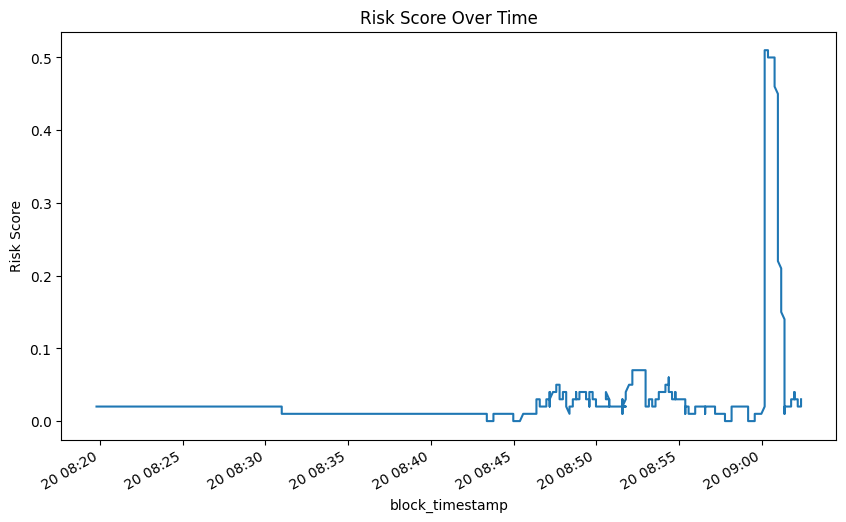

In [23]:
import matplotlib.pyplot as plt
# Plot risk score trends over time
plt.figure(figsize=(10, 6))
df.set_index('block_timestamp')['risk_score'].rolling(window=100).mean().plot(title="Risk Score Over Time")
plt.ylabel("Risk Score")
plt.show()


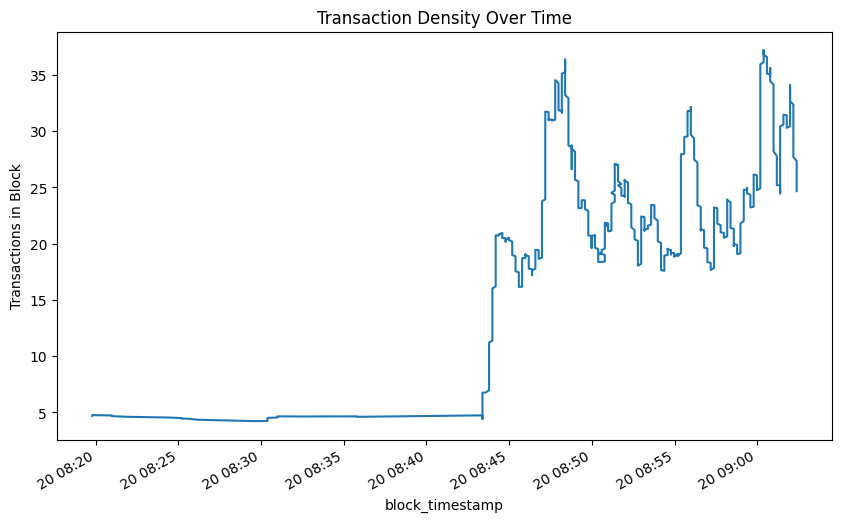

In [24]:
### 2. Congestion Analysis ###
# Congestion can be detected by analyzing high gas price and high transaction density
plt.figure(figsize=(10, 6))
df.set_index('block_timestamp')['transactions_in_block'].rolling(window=100).mean().plot(title="Transaction Density Over Time")
plt.ylabel("Transactions in Block")
plt.show()

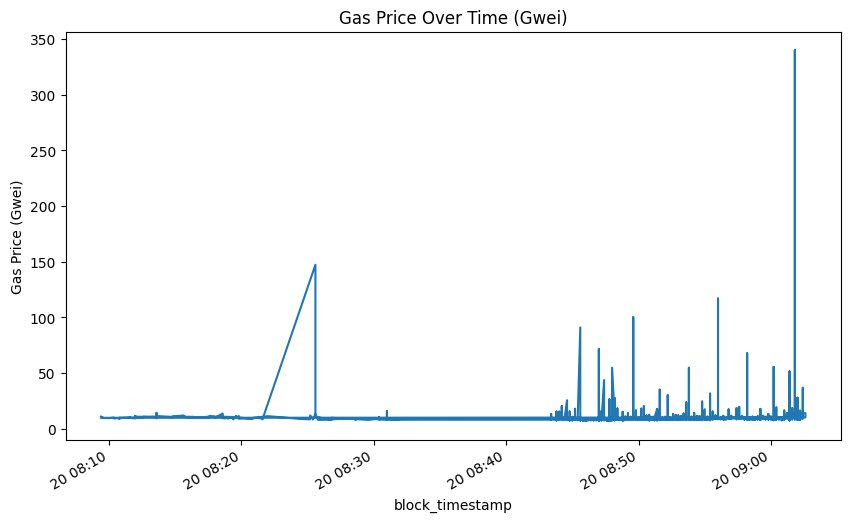

In [25]:
### 3. Gas Price Trend for Routing ###
# Plot gas price trend to identify high gas periods
plt.figure(figsize=(10, 6))
df.set_index('block_timestamp')['gas_price_gwei'].plot(title="Gas Price Over Time (Gwei)")
plt.ylabel("Gas Price (Gwei)")
plt.show()

In [26]:
### 4. Analyze Failed Transactions ###
failed_txns = df[df['receipt_status'] == 0]
print(f"Total Failed Transactions: {len(failed_txns)}")

Total Failed Transactions: 28


In [27]:
# Analyze high transaction density blocks
high_density_blocks = df[df['transactions_in_block'] > df['transactions_in_block'].mean()]
print(f"Blocks with High Transaction Density: {len(high_density_blocks)}")

Blocks with High Transaction Density: 931


In [28]:
df

,hash,nonce,transaction_index,from_address,to_address,ether_transferred,gas,gas_price,input,receipt_cumulative_gas_used,...,receipt_status,block_timestamp,block_hash,block_number,gas_price_gwei,transactions_in_block,is_high_gas,is_failed,is_congested,risk_score
0,0xef0a10e704911070a1f6254e7232c9ce4c3262cf8e0b...,704,9,0x4d4da657fda69460f8083120089ae066f3655108,0x14036de12ac0c96d4d5ed03e150d6558a43bbee5,0.100178,846761,9818233639,0x5327a3d2000000000000000000000000000000000000...,2526674,...,1,2024-10-20 08:10:47+00:00,0x459c09c033eec594589627d11131e460d630879eb633...,21005508,9.818234,3,False,False,False,0
1,0x799e14bce91bfca44bf2013e2350011a17cb2f7e4f0c...,0,186,0xc06b0b551a7f2ec79fdcb1c38d4f90f106e581ac,0xe21757357d5e37732b9e00bac8419dbd905cecc2,1.000000,23100,8936023203,0x,17822578,...,1,2024-10-20 08:10:47+00:00,0x459c09c033eec594589627d11131e460d630879eb633...,21005508,8.936023,3,False,False,False,0
2,0xdfd786cb2fcb82b22a601839075ed2087b5b8251a1f9...,2,221,0x265a7127d191705125531a38e6d60326b65c3b0a,0xdac17f958d2ee523a2206206994597c13d831ec7,0.000000,69718,9897023203,0xa9059cbb000000000000000000000000eb7144747917...,20296428,...,1,2024-10-20 08:10:47+00:00,0x459c09c033eec594589627d11131e460d630879eb633...,21005508,9.897023,3,False,False,False,0
3,0xc23ed620b3102d728047d3bc541ed96de56410a57792...,8,113,0x860a37a367f46a3f3559f90830ca1c6a0ae8b7d9,0x7f7de814d364dc5d6dab63bad14270ab762785a2,0.000000,98603,10000000000,0xa9059cbb000000000000000000000000945948724b91...,10111118,...,1,2024-10-20 08:11:59+00:00,0xbd202e917632101d40149716489c1a9c74a7884aba3b...,21005514,10.000000,7,False,False,False,0
4,0x12d7f4f1d56f3b9fc52cceffcc262a4db19be76bcf39...,9887093,37,0xdfd5293d8e347dfe59e90efd55b2956a1343963d,0x4d224452801aced8b2f0aebe155379bb5d594381,0.000000,207128,11599483892,0xa9059cbb000000000000000000000000fa103c21ea2d...,6421870,...,1,2024-10-20 08:11:59+00:00,0xbd202e917632101d40149716489c1a9c74a7884aba3b...,21005514,11.599484,7,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0x7a547bcad75f45e1e791b3c25c8b87261cf817e1a334...,0,138,0xb9ae25b91f42252c192cbcb1c3633e3669fd29a8,0x5e8e465b0bbd6fcf4282e223f25b8c2f2dc382ae,0.148448,21000,9826803383,0x,12297942,...,1,2024-10-20 09:02:23+00:00,0xe877f980f9ab0c05e681d16629331b2d3d29e61d1572...,21005764,9.826803,10,False,False,False,0
1996,0x686051998e7a324f12122512cd75fc0779712791d145...,62,18,0x45e280d079fccc83e6720b687ae41f8bb321f673,0x5182fede730b31a9cf7f49c5781214b4a99f2370,0.000042,306636,10199391012,0xc7c7f5b3000000000000000000000000000000000000...,4498473,...,1,2024-10-20 09:02:23+00:00,0xe877f980f9ab0c05e681d16629331b2d3d29e61d1572...,21005764,10.199391,10,False,False,False,0
1997,0x4e9f46ad4f0ba14519a1ee3f8f2db848e6c4a69b8970...,14,67,0x0a441f27b9c7d30c097d2d0cf0b99339c4e8cc8f,0x25e177677d077ffdd4950e9ff6321728a50a4d8b,0.003000,24150,11229391012,0x,9991825,...,1,2024-10-20 09:02:23+00:00,0xe877f980f9ab0c05e681d16629331b2d3d29e61d1572...,21005764,11.229391,10,False,False,False,0
1998,0xe656af51d05c063d69faf8c0d0eeffba3db4bce30946...,5,77,0x379a1014b3165c26062a9a29c3c641815c306111,0x7f7de814d364dc5d6dab63bad14270ab762785a2,0.000000,55785,10060972933,0xa9059cbb000000000000000000000000a1a52925369c...,10373131,...,1,2024-10-20 09:02:23+00:00,0xe877f980f9ab0c05e681d16629331b2d3d29e61d1572...,21005764,10.060973,10,False,False,False,0


In [29]:
df.dtypes

hash                                        object
nonce                                        int64
transaction_index                            int64
from_address                                object
to_address                                  object
ether_transferred                          float64
gas                                          int64
gas_price                                    int64
input                                       object
receipt_cumulative_gas_used                  int64
receipt_gas_used                             int64
receipt_contract_address                    object
receipt_root                               float64
receipt_status                               int64
block_timestamp                datetime64[ns, UTC]
block_hash                                  object
block_number                                 int64
gas_price_gwei                             float64
transactions_in_block                        int64
is_high_gas                    

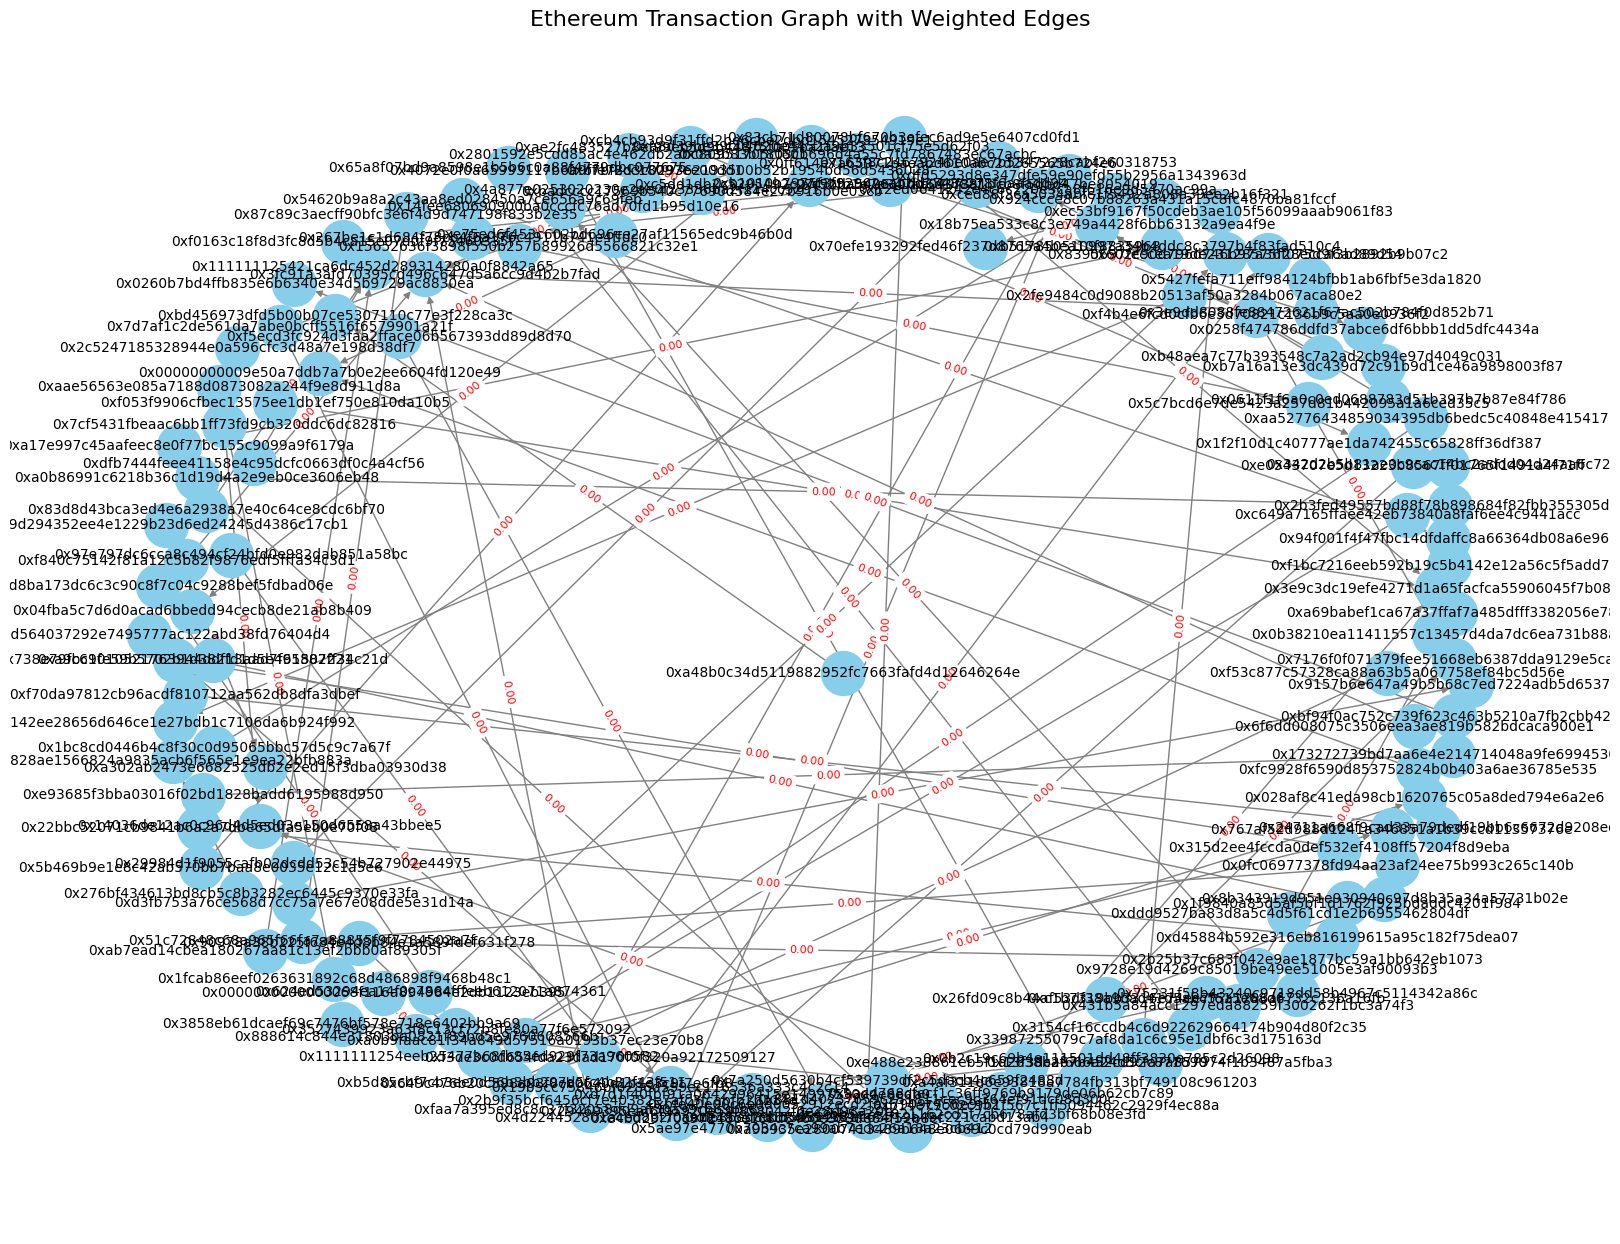

In [30]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Assuming df is your transaction DataFrame

# Create a directed graph
G = nx.DiGraph()

# Iterate over the rows of the DataFrame to add edges to the graph
for _, row in df.iterrows():
    # Calculate the transaction fee
    transaction_fee = row['gas'] * row['gas_price_gwei']  # Gas price already in Gwei
    congestion_score = row['transactions_in_block']
    risk_score = row['risk_score']

    # Check for zero values and skip this row if any score is zero
    if risk_score == 0 or congestion_score == 0 or transaction_fee == 0:
        continue  # Skip the row

    # Calculate weight
    weight = 1 / (risk_score * congestion_score * transaction_fee)

    # Add directed edge with transaction attributes
    G.add_edge(row['from_address'], row['to_address'], weight=weight, timestamp=row['block_timestamp'])

# Draw the graph using Matplotlib
plt.figure(figsize=(16, 12))  # Increase figure size

pos = nx.spring_layout(G, seed=42)  # Use spring layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10, node_color='skyblue', edge_color='gray', arrows=True)

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_color='red', font_size=8)

plt.title("Ethereum Transaction Graph with Weighted Edges", fontsize=16)
plt.axis('off')  # Turn off the axis
plt.show()

In [31]:
# For example, print the edges with their weights and timestamps
for edge in G.edges(data=True):
    print(f"Edge: {edge[0]} -> {edge[1]}, Weight: {edge[2]['weight']}, Timestamp: {edge[2]['timestamp']}")

Edge: 0xae2fc483527b8ef99eb5d9b44875f005ba1fae13 -> 0x1f2f10d1c40777ae1da742455c65828ff36df387, Weight: 1.0572743180184198e-09, Timestamp: 2024-10-20 09:01:47+00:00
Edge: 0x1fcab86eef0263631892c68d486898f9468b48c1 -> 0xaae56563e085a7188d0873082a244f9e8d911d8a, Weight: 1.1083198684615116e-07, Timestamp: 2024-10-20 09:00:11+00:00
Edge: 0xb1010b7975f3f92962eabbd2743c278f6aaadd94 -> 0xf0163c18f8d3fc8d5b4ca15e07d0f9f75460335f, Weight: 1.79078243562124e-08, Timestamp: 2024-10-20 08:43:47+00:00
Edge: 0x2b25b37c683f042e9ae1877bc59a1bb642eb1073 -> 0x51c72848c68a965f66fa7a88855f9f7784502a7f, Weight: 5.4945170392484574e-09, Timestamp: 2024-10-20 08:45:35+00:00
Edge: 0x97e797dc6cca8c494cf24bfd0e982dab851a58bc -> 0xf3de3c0d654fda23dad170f0f320a92172509127, Weight: 4.166162756053495e-08, Timestamp: 2024-10-20 08:46:23+00:00
Edge: 0xaacd768cfecf1c36ff9769b9179de06b62cb7c89 -> 0x14036de12ac0c96d4d5ed03e150d6558a43bbee5, Weight: 8.987246733641332e-09, Timestamp: 2024-10-20 08:46:23+00:00
Edge: 0xbfe78d

In [32]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

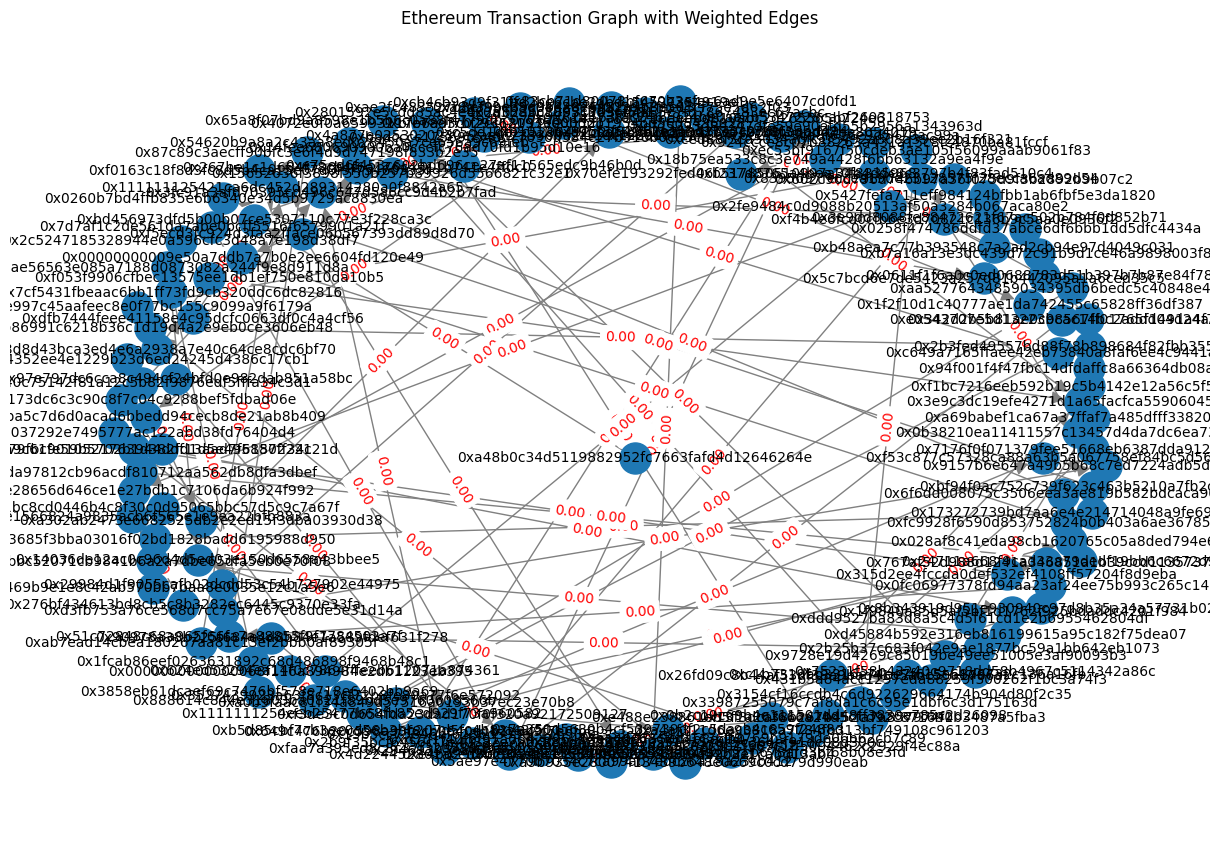

In [33]:
# Create a directed graph
G = nx.DiGraph()

# Dictionary to hold node features
node_features = {}

# Iterate over the rows of the DataFrame to add edges to the graph
for _, row in df.iterrows():
    # Calculate the transaction fee
    transaction_fee = row['gas'] * row['gas_price_gwei']  # Gas price already in Gwei
    congestion_score = row['transactions_in_block']
    risk_score = row['risk_score']
    ether_transferred = float(row['ether_transferred'])  # Ensure this is a float

    # Check for zero values and skip this row if any score is zero
    if risk_score == 0 or congestion_score == 0 or transaction_fee == 0:
        continue  # Skip the row

    # Calculate weight
    weight = 1 / (risk_score * congestion_score * transaction_fee)

    # Add directed edge
    G.add_edge(row['from_address'], row['to_address'], weight=weight, timestamp=row['block_timestamp'])

    # Update node features for from_address
    if row['from_address'] not in node_features:
        node_features[row['from_address']] = {
            'ether_transferred': 0.0,  # Initialize ether_transferred
            'total_outgoing': 0,        # Count of outgoing transactions
            'total_incoming': 0          # Initialize incoming transactions
        }
    
    node_features[row['from_address']]['ether_transferred'] += ether_transferred
    node_features[row['from_address']]['total_outgoing'] += 1

    # Update node features for to_address
    if row['to_address'] not in node_features:
        node_features[row['to_address']] = {
            'ether_transferred': 0.0,  # Initialize ether_transferred
            'total_outgoing': 0,        # Initialize outgoing transactions
            'total_incoming': 0         # Count of incoming transactions
        }
    
    node_features[row['to_address']]['ether_transferred'] += ether_transferred
    node_features[row['to_address']]['total_incoming'] += 1  # Increment incoming transactions

# Assign the node features as attributes to the nodes in the graph
for node, features in node_features.items():
    G.nodes[node]['ether_transferred'] = features['ether_transferred']
    G.nodes[node]['total_outgoing'] = features['total_outgoing']
    G.nodes[node]['total_incoming'] = features['total_incoming']

# Draw the graph using Matplotlib without node features
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Use spring layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, arrowstyle='-|>', arrowsize=20, edge_color='gray')

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_color='red')

plt.title("Ethereum Transaction Graph with Weighted Edges")
plt.axis('off')  # Turn off the axis
plt.show()

In [34]:
# Print node features for the model, indicating from_address and to_address involvement
print("Node Features:")
for node in G.nodes(data=True):
    outgoing_count = node[1]['total_outgoing']
    incoming_count = node[1]['total_incoming']

    # Determine type based on outgoing and incoming counts
    if outgoing_count > 0 and incoming_count > 0:
        node_type = 'Both'
    elif outgoing_count > 0:
        node_type = 'From Address'
    elif incoming_count > 0:
        node_type = 'To Address'
    else:
        node_type = 'Isolated'

    print(f"Node: {node[0]}, Type: {node_type}, Features: {node[1]}")

# Print edges with their weights and timestamps
print("\nEdges:")
for edge in G.edges(data=True):
    print(f"Edge: {edge[0]} -> {edge[1]}, Weight: {edge[2]['weight']}, Timestamp: {edge[2]['timestamp']}")

Node Features:
Node: 0xae2fc483527b8ef99eb5d9b44875f005ba1fae13, Type: From Address, Features: {'ether_transferred': 1.4599999999999998e-07, 'total_outgoing': 6, 'total_incoming': 0}
Node: 0x1f2f10d1c40777ae1da742455c65828ff36df387, Type: To Address, Features: {'ether_transferred': 1.4599999999999998e-07, 'total_outgoing': 0, 'total_incoming': 6}
Node: 0x1fcab86eef0263631892c68d486898f9468b48c1, Type: From Address, Features: {'ether_transferred': 0.028, 'total_outgoing': 1, 'total_incoming': 0}
Node: 0xaae56563e085a7188d0873082a244f9e8d911d8a, Type: To Address, Features: {'ether_transferred': 0.028, 'total_outgoing': 0, 'total_incoming': 1}
Node: 0xb1010b7975f3f92962eabbd2743c278f6aaadd94, Type: From Address, Features: {'ether_transferred': 0.0, 'total_outgoing': 1, 'total_incoming': 0}
Node: 0xf0163c18f8d3fc8d5b4ca15e07d0f9f75460335f, Type: To Address, Features: {'ether_transferred': 0.0, 'total_outgoing': 0, 'total_incoming': 1}
Node: 0x2b25b37c683f042e9ae1877bc59a1bb642eb1073, Type:

In [35]:
import spektral
import tensorflow as tf
from tensorflow.keras import layers

In [36]:
"""1. Modify Dijkstra’s Algorithm to Maximize Path Weight:
Normally, Dijkstra’s algorithm finds the shortest path (minimizing the sum of distances). Instead, we want to maximize the path weights (product of the edge weights).
We can apply a logarithmic transformation because maximizing the product of weights is equivalent to maximizing the sum of their logarithms:
maximize 
∏
(
𝑤
𝑖
)
 is equivalent to minimizing 
−
∑
log
⁡
(
𝑤
𝑖
)
maximize ∏(w 
i
​
 ) is equivalent to minimizing −∑log(w 
i
​
 )
2. Use the Inverted Weights in Dijkstra’s Algorithm:
We'll take the logarithm of each edge weight and run Dijkstra’s algorithm to minimize the negative logarithms, effectively maximizing the product of the weights."""

"1. Modify Dijkstra’s Algorithm to Maximize Path Weight:\nNormally, Dijkstra’s algorithm finds the shortest path (minimizing the sum of distances). Instead, we want to maximize the path weights (product of the edge weights).\nWe can apply a logarithmic transformation because maximizing the product of weights is equivalent to maximizing the sum of their logarithms:\nmaximize\xa0\n∏\n(\n𝑤\n𝑖\n)\n\xa0is\xa0equivalent\xa0to\xa0minimizing\xa0\n−\n∑\nlog\n\u2061\n(\n𝑤\n𝑖\n)\nmaximize\xa0∏(w \ni\n\u200b\n )\xa0is\xa0equivalent\xa0to\xa0minimizing\xa0−∑log(w \ni\n\u200b\n )\n2. Use the Inverted Weights in Dijkstra’s Algorithm:\nWe'll take the logarithm of each edge weight and run Dijkstra’s algorithm to minimize the negative logarithms, effectively maximizing the product of the weights."

In [37]:
import networkx as nx
import math
import heapq

# Function to find the optimal path (maximum weight) between two addresses
def find_optimal_path_max_weight(graph, source, target, use_node_features=False):
    """
    Find the optimal path between 'source' and 'target' nodes that maximizes the product of edge weights.
    Optionally, include node features in the decision-making process.
    
    Parameters:
    - graph: Directed graph (DiGraph) from NetworkX with edge attribute 'weight'.
    - source: Starting node (from_address).
    - target: Target node (to_address).
    - use_node_features: Whether to use node features (Type, Features) in decision-making.
    
    Returns:
    - path: The optimal path as a list of nodes from 'source' to 'target'.
    - max_weight_product: The product of weights for the optimal path.
    """
    
    # Priority queue (min-heap), but we store negative log(weight) to maximize product of weights
    queue = [(0, source, [])]  # (negative log(weight), current_node, path_so_far)
    visited = set()

    # Loop until the queue is empty
    while queue:
        (cost, current_node, path) = heapq.heappop(queue)

        # Skip the node if it's already been visited
        if current_node in visited:
            continue

        # Add the current node to the visited set
        visited.add(current_node)

        # Add current node to path
        path = path + [current_node]

        # If we reached the target, return the path and the maximum product of weights
        if current_node == target:
            return path, math.exp(-cost)  # Returning the exp(-cost) as we applied log transform

        # Explore neighbors
        for neighbor in graph.neighbors(current_node):
            if neighbor not in visited:
                # Get the edge weight
                weight = graph[current_node][neighbor]['weight']
                
                # Optionally incorporate node features into the weight
                if use_node_features:
                    current_node_feature = graph.nodes[current_node].get('Features', 1)
                    neighbor_node_feature = graph.nodes[neighbor].get('Features', 1)
                    # Modify weight based on node features (as an example, multiply by features)
                    weight *= current_node_feature * neighbor_node_feature

                # Take the logarithm of the weight and add it to the cost (negative log since we want to maximize)
                new_cost = cost - math.log(weight)  # Negative log for maximization

                # Push the neighbor with the updated cost to the priority queue
                heapq.heappush(queue, (new_cost, neighbor, path))

    return None, 0  # If no path is found

In [38]:
# Iterate through the nodes and determine their type based on outgoing and incoming counts
for node, attributes in G.nodes(data=True):
    outgoing_count = attributes.get('total_outgoing', 0)
    incoming_count = attributes.get('total_incoming', 0)

    # Determine node type
    if outgoing_count > 0 and incoming_count > 0:
        node_type = 'Both'
    elif outgoing_count > 0:
        node_type = 'From Address'
    elif incoming_count > 0:
        node_type = 'To Address'
    else:
        node_type = 'Isolated'

    # Add node type to the node's attributes
    G.nodes[node]['Type'] = node_type

# Find the first 'From Address' and 'To Address' in the graph
from_address = None
to_address = None

# Iterate through nodes to find one 'From Address' and one 'To Address'
for node, attributes in G.nodes(data=True):
    if attributes['Type'] == 'From Address' and from_address is None:
        from_address = node
    elif attributes['Type'] == 'To Address' and to_address is None:
        to_address = node

# Ensure both addresses are found
if from_address and to_address:
    # Call the function to find the optimal path between the source (From Address) and target (To Address)
    path, max_weight_product = find_optimal_path_max_weight(G, from_address, to_address)

    # Output the results
    if path:
        print(f"Optimal Path: {' -> '.join(path)}")
        print(f"Max Weight Product: {max_weight_product:.6f}")
    else:
        print(f"No path found from {from_address} to {to_address}")
else:
    print("Either the source (From Address) or target (To Address) address could not be found.")



Optimal Path: 0xae2fc483527b8ef99eb5d9b44875f005ba1fae13 -> 0x1f2f10d1c40777ae1da742455c65828ff36df387
Max Weight Product: 0.000000


In [39]:
def find_path_with_max_edge_weight(graph, source, target):
    """
    Find the path from 'source' to 'target' where at each step, the edge weight is the maximum available.
    
    Parameters:
    - graph: Directed graph (DiGraph) from NetworkX with edge attribute 'weight'.
    - source: Starting node (from_address).
    - target: Target node (to_address).
    
    Returns:
    - path: The path as a list of nodes from 'source' to 'target' that follows maximum edge weight.
    - total_max_weight: The sum of maximum weights along the path.
    """
    # Initialize variables for tracking
    current_node = source
    path = [source]
    total_max_weight = 0
    
    while current_node != target:
        # Get all outgoing edges from the current node
        outgoing_edges = list(graph.out_edges(current_node, data=True))
        
        # If there are no outgoing edges, return no path
        if not outgoing_edges:
            return None, 0
        
        # Find the edge with the maximum weight
        max_edge = max(outgoing_edges, key=lambda edge: edge[2]['weight'])
        
        # Update current node and accumulate total weight
        current_node = max_edge[1]
        total_max_weight += max_edge[2]['weight']
        
        # Add the new node to the path
        path.append(current_node)
        
        # If we reached the target, break out
        if current_node == target:
            break
    
    return path, total_max_weight


# Find the first 'From Address' and 'To Address' in the graph
from_address = None
to_address = None

# Iterate through nodes to find one 'From Address' and one 'To Address'
for node, attributes in G.nodes(data=True):
    if attributes['Type'] == 'From Address' and from_address is None:
        from_address = node
    elif attributes['Type'] == 'To Address' and to_address is None:
        to_address = node

# Ensure both addresses are found
if from_address and to_address:
    # Call the function to find the path with the maximum edge weight
    path, total_max_weight = find_path_with_max_edge_weight(G, from_address, to_address)

    # Output the results
    if path:
        print(f"Path with Maximum Edge Weight: {' -> '.join(path)}")
        print(f"Total Maximum Edge Weight: {total_max_weight:.6f}")
    else:
        print(f"No path found from {from_address} to {to_address}")
else:
    print("Either the source (From Address) or target (To Address) address could not be found.")


Path with Maximum Edge Weight: 0xae2fc483527b8ef99eb5d9b44875f005ba1fae13 -> 0x1f2f10d1c40777ae1da742455c65828ff36df387
Total Maximum Edge Weight: 0.000000
